In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from flytrailvr.utils import extract_data,process_important_variables,plot_trajectory,config_to_title

# generate linear color map from two colors in matplotlib
from matplotlib.colors import LinearSegmentedColormap

pkor = LinearSegmentedColormap.from_list('pkor', ['pink', 'crimson'], N=256)
blnv = LinearSegmentedColormap.from_list('blnv', ['lightskyblue', 'royalblue'], N=256)
    

In [7]:
# data folder
data_folder = '../data/charlie_rig_rishika/'

In [8]:
data = list(filter(lambda x: os.path.isdir(os.path.join(data_folder, x)), os.listdir(data_folder)))
dates = [pd.to_datetime(x.split('_')[-1], format='%Y%m%d-%H%M%S') for x in data]
# sort by date
data = [x for _, x in sorted(zip(dates, data))]
for d in data:
    print(d)

low_wind_wide_20240319-141201
low_wind_thin_20240319-150617
orco_thinstrip_with_odor_20240320-164441
orco_thinstrip_test_20240320-173646
orco_thinstrip_test_20240320-173843
orco_thinstrip_test_20240320-174642
orco_thinstrip_20240321-112203
orco_thinstrip_20240321-112442
orco_thinstrip_low_wind_20240321-114717
orco_thinstrip__no_wind_visual_20240321-121715
orco_thinstrip_low_wind_20240321-150513
orco_thinstrip_low_wind_20240321-151534
orco_alternated_wind_20240321-153548
orco_alternated_wind_48hr_20240322-105843
orco_thinstrip_lowwind_20240322-114228
orco_alternated_wind_20240322-131005
orco_alternated_wind_20240326-105020
orco_alternated_wind_continued_20240326-110233
orco_alternated_wind_20240326-120252
orco_thinstrip_20240326-125708
orco_alternated_wind_20240326-143951
orco_alternated_wind_continued_20240326-144619


Processing low_wind_wide_20240319-141201


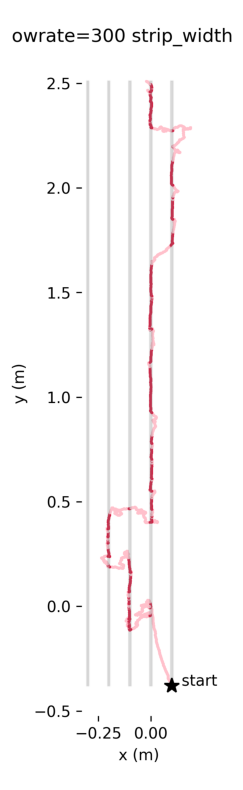

Processing low_wind_thin_20240319-150617


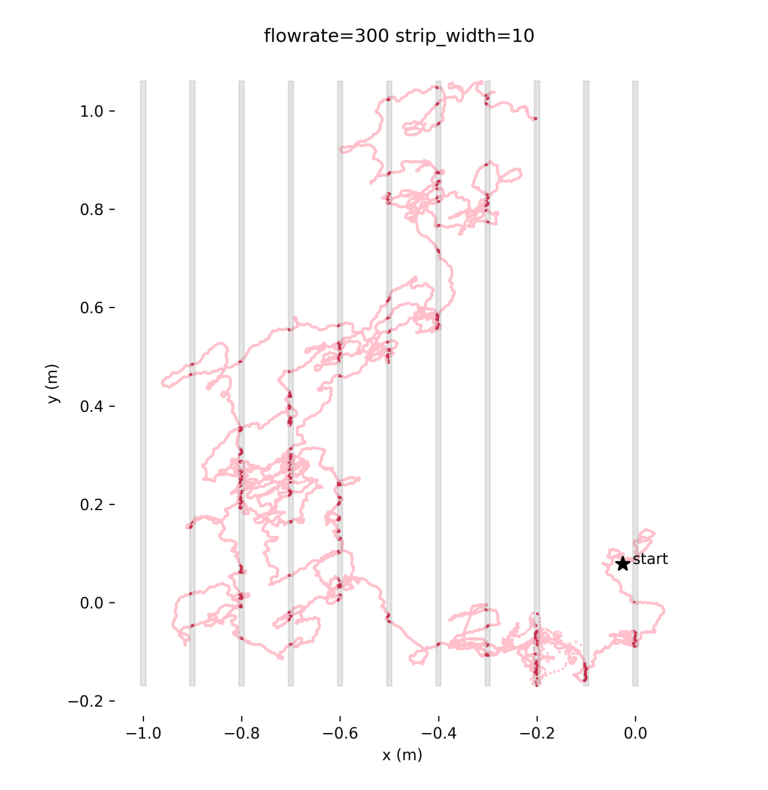

Processing orco_thinstrip_with_odor_20240320-164441


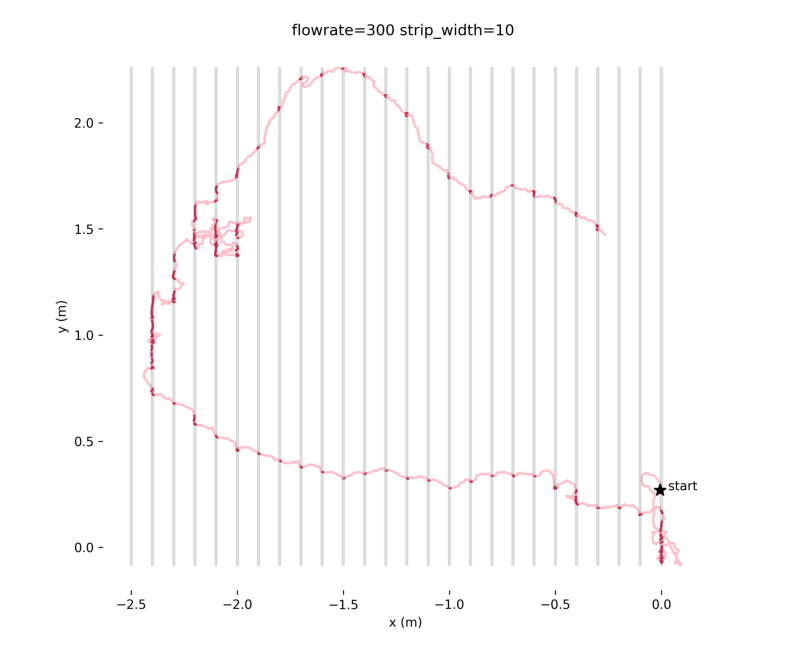

Processing orco_thinstrip_test_20240320-173646
Error in orco_thinstrip_test_20240320-173646: single positional indexer is out-of-bounds
Processing orco_thinstrip_test_20240320-173843


/Users/neurorishika/Projects/Rotations/RutaLab/FlyTrailVR/flytrailvr/utils.py:34: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


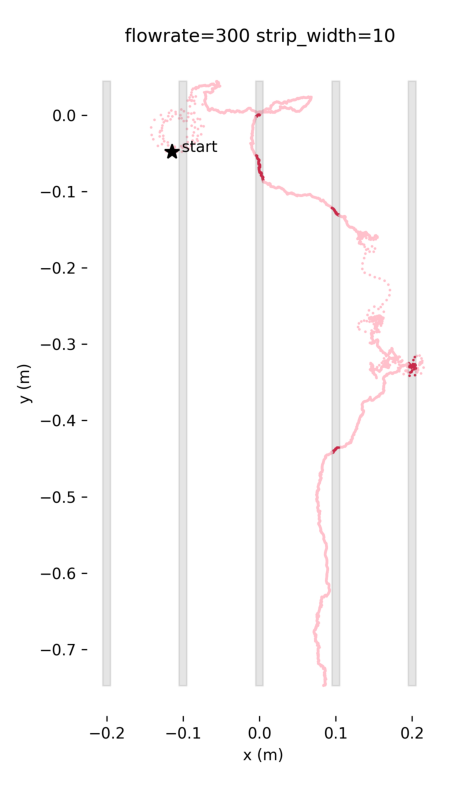

Processing orco_thinstrip_test_20240320-174642


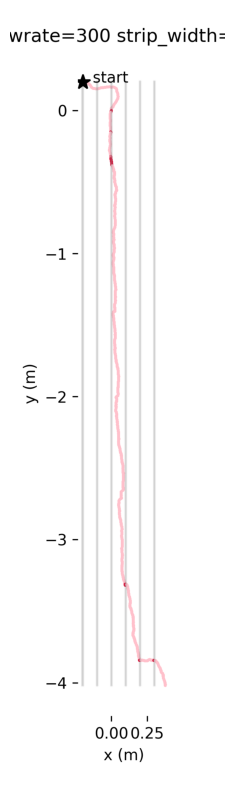

Processing orco_thinstrip_20240321-112203
Error in orco_thinstrip_20240321-112203: single positional indexer is out-of-bounds
Processing orco_thinstrip_20240321-112442


/Users/neurorishika/Projects/Rotations/RutaLab/FlyTrailVR/flytrailvr/utils.py:34: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


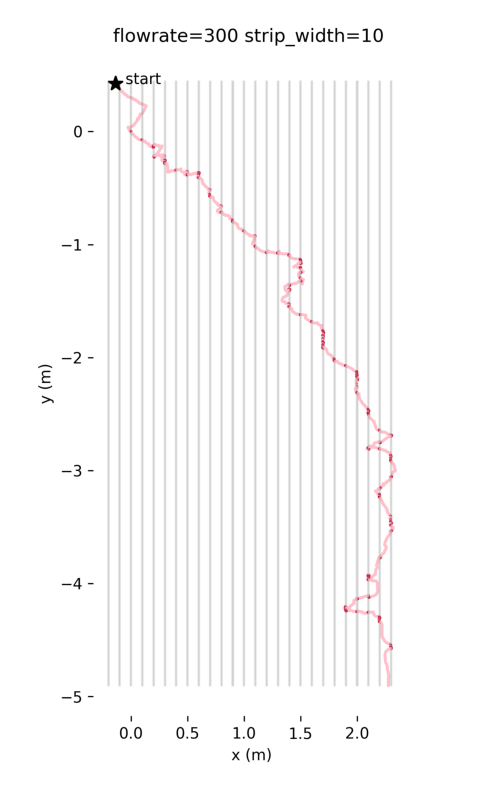

Processing orco_thinstrip_low_wind_20240321-114717


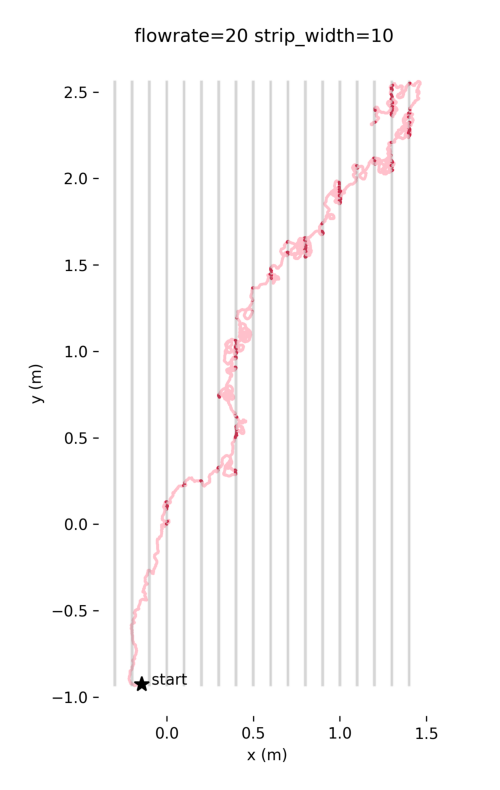

Processing orco_thinstrip__no_wind_visual_20240321-121715


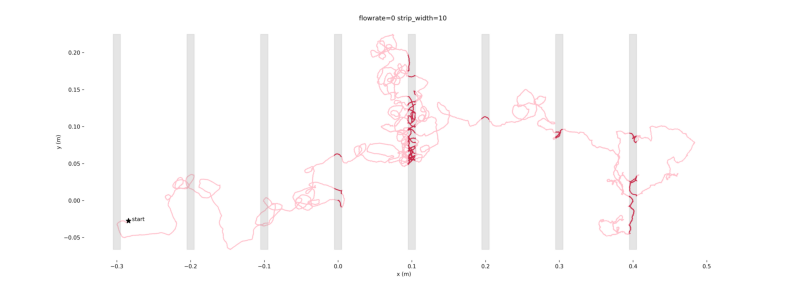

Processing orco_thinstrip_low_wind_20240321-150513


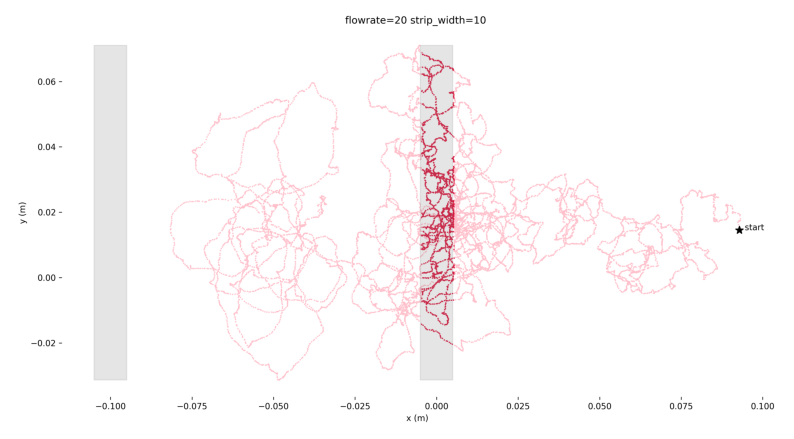

Processing orco_thinstrip_low_wind_20240321-151534


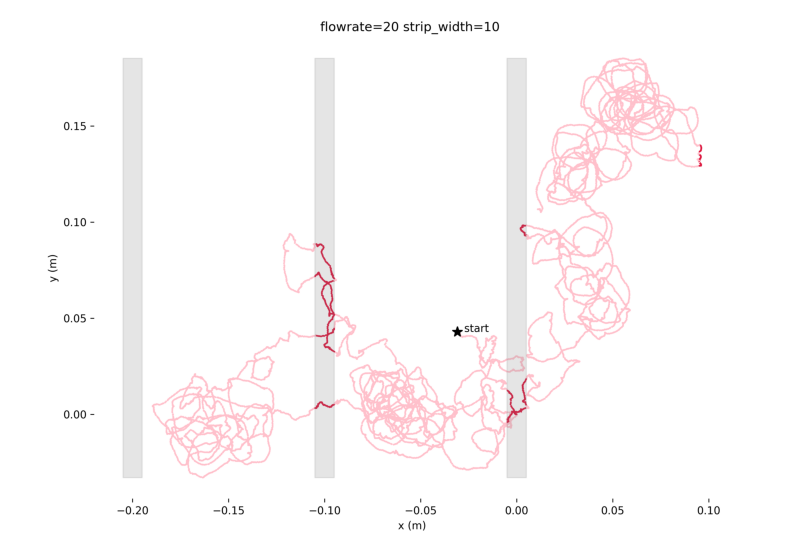

Processing orco_alternated_wind_20240321-153548


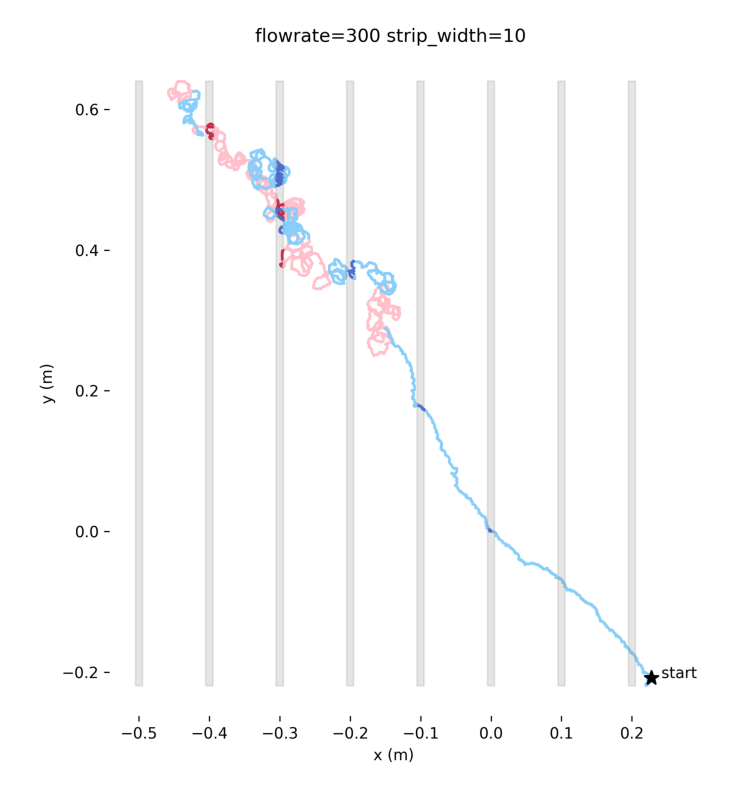

Processing orco_alternated_wind_48hr_20240322-105843


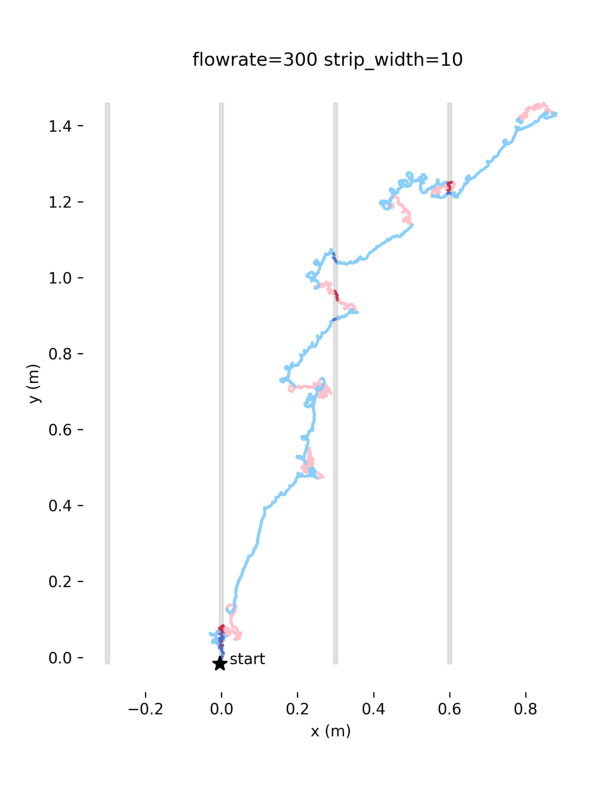

Processing orco_thinstrip_lowwind_20240322-114228


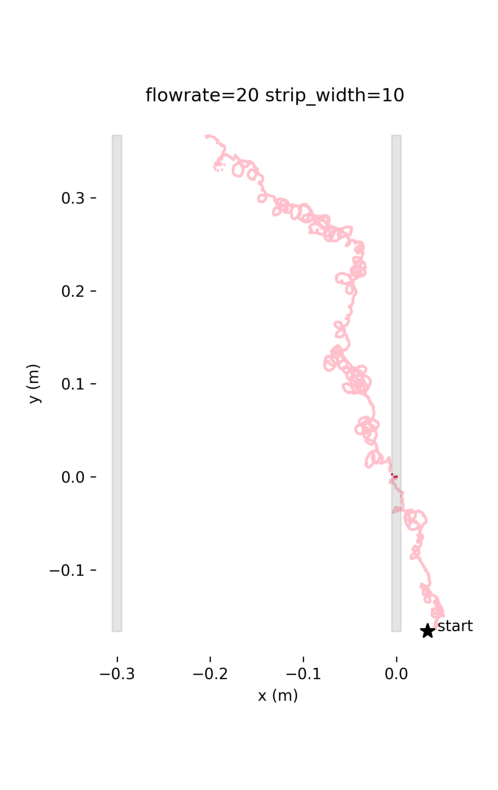

Processing orco_alternated_wind_20240322-131005


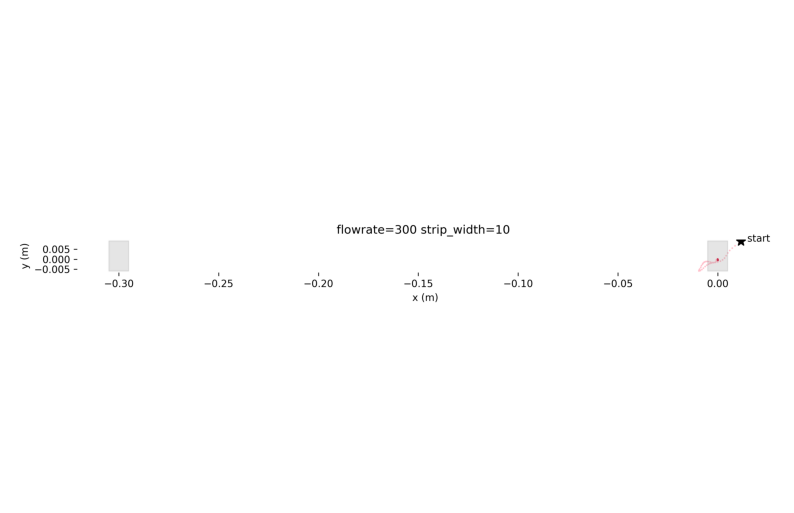

Processing orco_alternated_wind_20240326-105020


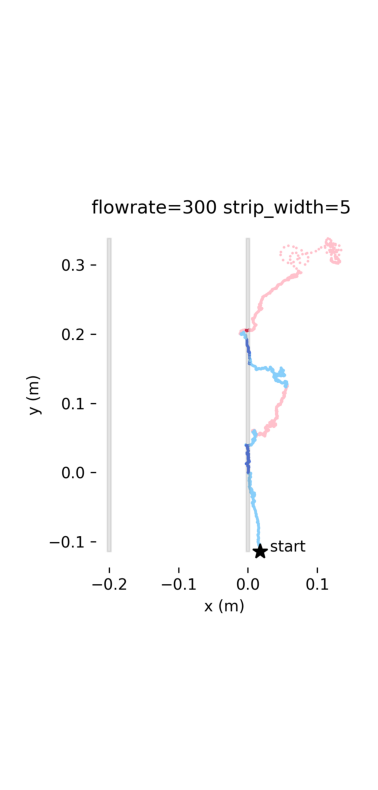

Processing orco_alternated_wind_continued_20240326-110233


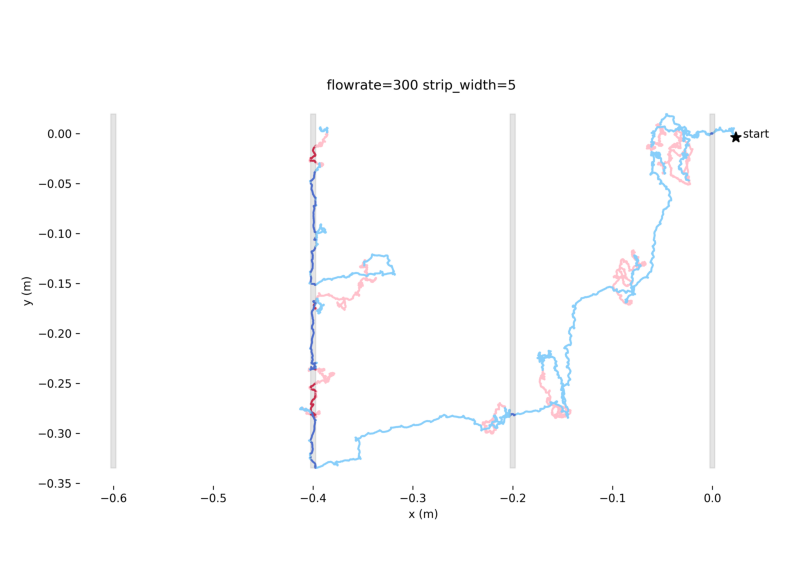

Processing orco_alternated_wind_20240326-120252


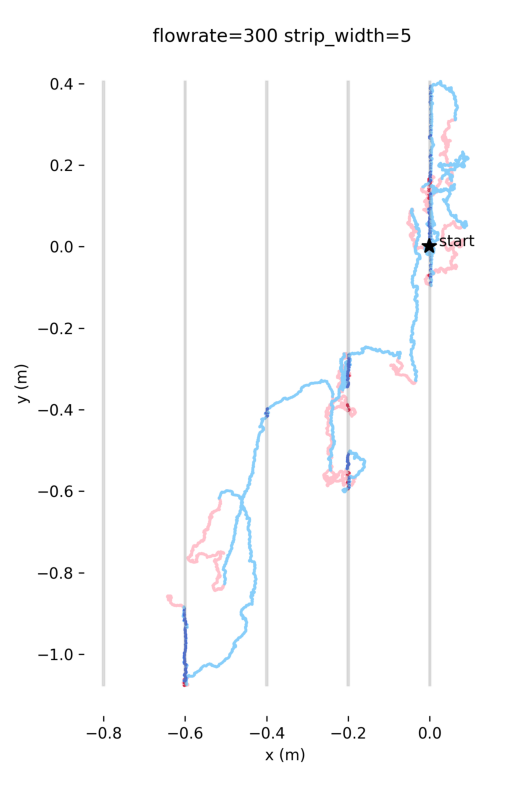

Processing orco_thinstrip_20240326-125708


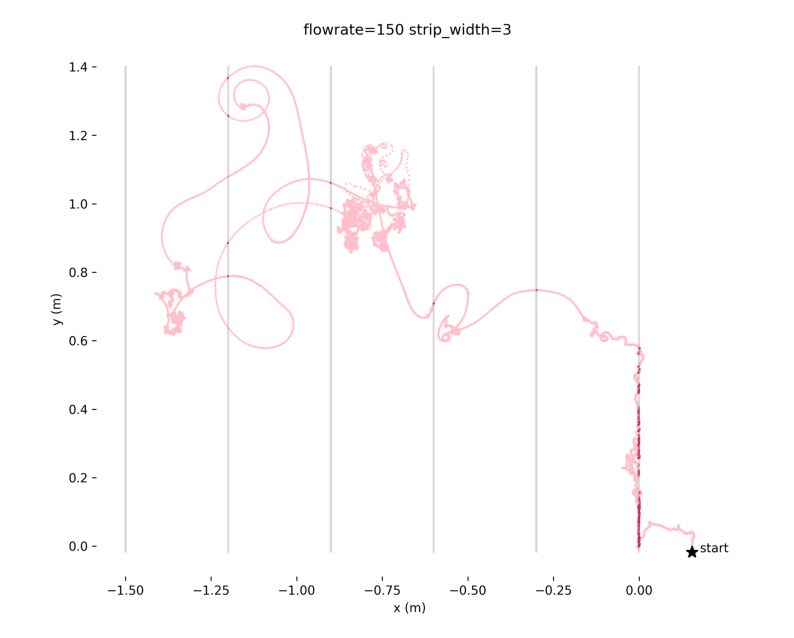

Processing orco_alternated_wind_20240326-143951


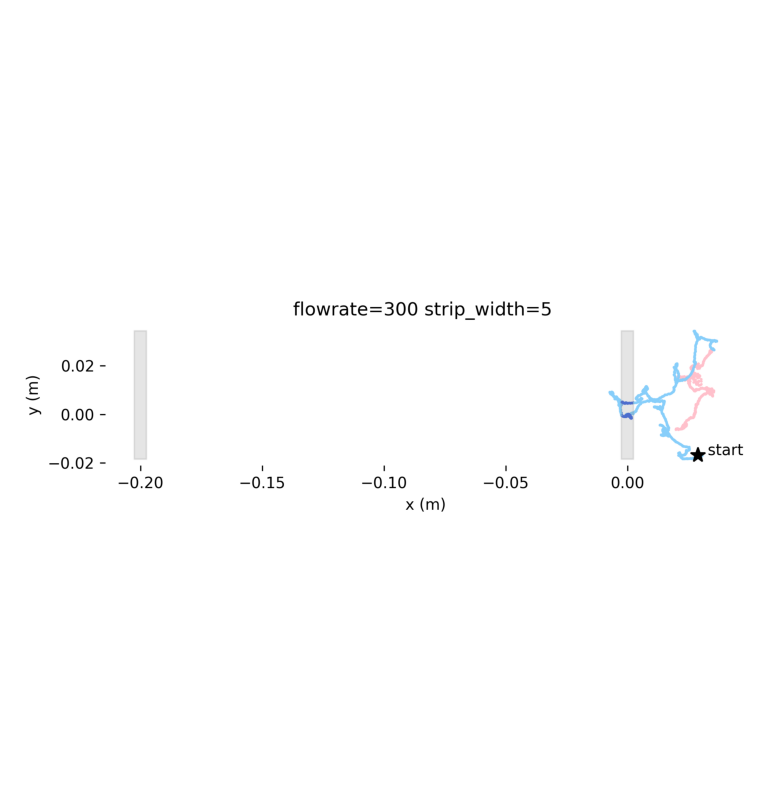

Processing orco_alternated_wind_continued_20240326-144619


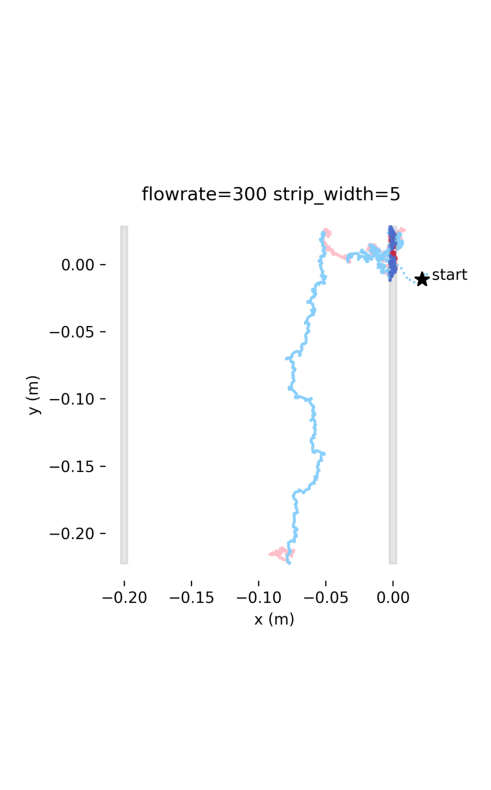

In [9]:
replot = False
for sample_data in data:
    print(f'Processing {sample_data}')
    save_path = [os.path.join(data_folder, sample_data, 'trajectory.png'),'figures/'+sample_data+'.png']
    # check if the figure already exists
    if not replot and all([os.path.exists(x) for x in save_path]):
        # show the existing figure at high resolution
        plt.figure(figsize=(10, 10))
        plt.imshow(plt.imread(save_path[0], format='png'))
        plt.axis('off')
        plt.show()
        continue
    try:
        df, config, logic, comments = extract_data(os.path.join(data_folder, sample_data))
        plot_trajectory(df, config, scale_factor=7, show=True, save=save_path, colormaps=[pkor, blnv], odor_or_led='led' if 'orco' in sample_data else 'odor')
    except Exception as e:
        print(f'Error in {sample_data}: {e}')

In [ ]:
config

{'instant_replay': False,
 'include_pre_air': True,
 'log_dir': '/home/rutalab/Desktop/log_files/',
 'strip_angle': 0,
 'strip_direction': 'right',
 'strip_width': 3,
 'periodic_boundary': True,
 'period_width': 300,
 'flowrate': 150,
 'percent_odor': 20,
 'pre_onset_time': 120,
 'led_intensity': 100,
 'led_color': 'red',
 'window_len': 120,
 'pulse_period': 10.0}

In [ ]:
speedup_factor = 100
frame_rate = 60

duration = t.max()-t.min()
run_time = duration/speedup_factor
n_frames = int(run_time*frame_rate)
time_between_frames = duration/n_frames

times_to_show = np.arange(t.min(), t.max(), time_between_frames)
# find the nearest time to the times to show
frames = []
for time in times_to_show:
    frame = np.argmin(np.abs(t-time))
    frames.append(frame)

In [ ]:
duration/60


25.677659116666668

Frames:   0%|          | 0/924 [00:00<?, ?it/s]

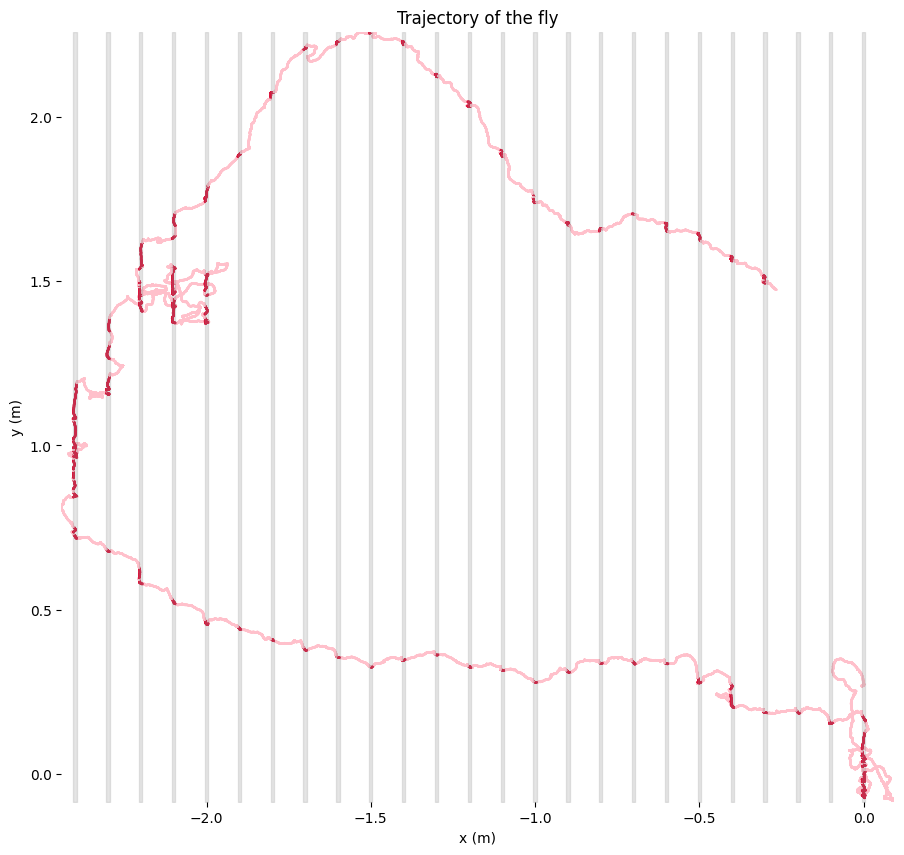

In [ ]:
# convert to a mp4 animation
import matplotlib.animation as animation
from tqdm.notebook import tqdm

fig, ax = plt.subplots(figsize=(xby*scale_factor+1, scale_factor))
ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_title('Trajectory of the fly')
ax.set_aspect('equal')
# remove the box
for spine in ax.spines.values():
    spine.set_visible(False)

sc = ax.scatter([], [], c=[], cmap=pkor, s=0.5)
# add the odor lines
max_x = int(x.max()//period_width)
min_x = int(x.min()//period_width)
for i in range(min_x, max_x+1, 1):
    start_x = i*period_width-strip_width/2
    end_x = i*period_width+strip_width/2
    ax.fill_betweenx([y.min(), y.max()], start_x, end_x, color='grey', alpha=0.2)

def update(frame):
    sc.set_offsets(np.c_[x[:frame], y[:frame]])
    # set the color
    sc.set_color(pkor(odor[:frame]))
    return sc,

ani = animation.FuncAnimation(fig, update, frames=tqdm(frames, desc='Frames'), blit=True)
ani.save(f'figures/{sample_data}_trajectory.mp4', fps=frame_rate, dpi=300)
